# The Stanford Sentiment Treebank 
The Stanford Sentiment Treebank consists of sentences from movie reviews and human annotations of their sentiment. The task is to predict the sentiment of a given sentence. We use the two-way (positive/negative) class split, and use only sentence-level labels.

In [1]:
from IPython.display import display, Markdown
with open('../../doc/env_variables_setup.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

Environment variables that need to be defined:   
`export DIR_PROJ=your_path_git_repository`  
`export PYTHONPATH=$DIR_PROJ/src`  
`export PATH_TENSORBOARD=your_path_tensorboard`  
`export PATH_DATASETS=your_path_datasets`  
`export PROJECT_ID=your_gcp_project_id`  
`export BUCKET_NAME=your_gcp_gs_bucket_name`  
`export REGION=your_region`  
`export PATH_SAVE_MODEL=your_path_to_save_model` 

- Use local Jupyter Lab 
    - you need to have the `jupyter-notebook` Anaconda python environment created [link](local_jupyter_lab_installation.md) 
    - you need to have the `jupyter-notebook` Anaconda python environment activated [link](local_jupyter_lab_installation.md) 
    - then define the environment variables above (copy and paste) 
    - you need to have the `env_multilingual_class` Anaconda python environment created [link](local_jupyter_lab_installation.md)  
    - start Jupyter Lab:  `jupyter lab` 
    - open a Jupyter Lab notebook from `notebook/` 
     - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - choose the proper Anaconda python environment:  `Python [conda env:env_multilingual_class]` [link](conda_env.md) 
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`


- Use GCP Jupyter Lab 
    - Go on GCP
    - open a Cloud Shell
    - `ssh-keygen -t rsa -b 4096 -C firstName_lastName`
    - `cp .ssh/id_rsa.pub .`
    - use Cloud Editor to edit this file `id_rsa.pub` and copy the full content
    - Go on Compute Engine -> Metadata
    - Click SSH Keys
    - Click Edit
    - Click + Add item, copy the content of `id_rsa.pub`
    - You should see firstName_lastName of the left
    - Click Save
    - you need to start a AI Platform instance 
    - open a Jupyter Lab terminal and got to `/home/gcp_user_name/`
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - then `cd proj_multilingual_text_classification/`
    - create the Anacond Python environment `conda env create -f env/environment.yml`
    - create a file `config.sh` in `/home` with the following information: 
    ```
    #!/bin/bash
    
    echo "applying some configuration ..."
    git config --global user.email user_email
    git config --global user.name user_name
    git config --global credential.helper store
        
    # Add here the enviroment variables from above below
    # [EDIT ME]
    export DIR_PROJ=your_path_git_repository
    export PYTHONPATH=$DIR_PROJ/src
  
    cd /home/gcp_user_name/
    
    conda activate env_multilingual_class

    export PS1='\[\e[91m\]\u@:\[\e[32m\]\w\[\e[0m\]$'
    ```
    - Got to AI Platform Notebook, select your instance and click "Reset".
    - Wait and reshreh you Web browser with the Notebook


## Import Packages

In [2]:
import tensorflow as tf
import tensorflow_datasets

from tensorflow.keras.utils import to_categorical

from transformers import (
    BertConfig,
    BertTokenizer,
    TFBertModel,
    TFBertForSequenceClassification,
    glue_convert_examples_to_features,
    glue_processors
)

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

import math
import numpy as np
import os
import time
from datetime import timedelta
import shutil
from datetime import datetime

## Check configuration

In [3]:
print(tf.version.GIT_VERSION, tf.version.VERSION)

v2.2.0-rc1-34-ge6e5d6df2a 2.2.0-rc2


In [4]:
print(tf.keras.__version__)

2.3.0-tf


In [5]:
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)>0:
    for gpu in gpus:
        print('Name:', gpu.name, '  Type:', gpu.device_type)
else:
    print('No GPU available !!!!')

Name: /physical_device:GPU:0   Type: GPU


## Define Paths

In [6]:
try:
    data_dir=os.environ['PATH_DATASETS']
except KeyError:
    print('missing PATH_DATASETS')
try:   
    tensorboard_dir=os.environ['PATH_TENSORBOARD']
except KeyError:
    print('missing PATH_TENSORBOARD')
try:   
    checkpoint_dir=os.environ['PATH_SAVE_MODEL']
except KeyError:
    print('missing PATH_SAVE_MODEL')

## Import local packages

In [7]:
import preprocessing.preprocessing as pp
import utils.model_metrics as mm

In [8]:
import importlib
importlib.reload(pp);
importlib.reload(mm);

## Loading a data from Tensorflow Datasets

In [9]:
data, info = tensorflow_datasets.load(name='glue/sst2',
                                      data_dir=data_dir,
                                      with_info=True)

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset glue (/home/fabien_tarrade/data/glue/sst2/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /home/fabien_tarrade/data/glue/sst2/1.0.0


### Checking baics info from the metadata

In [10]:
info

tfds.core.DatasetInfo(
    name='glue',
    version=1.0.0,
    description='GLUE, the General Language Understanding Evaluation benchmark
(https://gluebenchmark.com/) is a collection of resources for training,
evaluating, and analyzing natural language understanding systems.

            The Stanford Sentiment Treebank consists of sentences from movie reviews and
            human annotations of their sentiment. The task is to predict the sentiment of a
            given sentence. We use the two-way (positive/negative) class split, and use only
            sentence-level labels.',
    homepage='https://nlp.stanford.edu/sentiment/index.html',
    features=FeaturesDict({
        'idx': tf.int32,
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'sentence': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=70042,
    splits={
        'test': 1821,
        'train': 67349,
        'validation': 872,
    },
    supervised_keys=None,
    citation="""@

In [11]:
pp.print_info_dataset(info)

Labels:
      ['negative', 'positive']

Number of label:
      2

Structure of the data:
      dict_keys(['sentence', 'label', 'idx'])

Number of entries:
   Train dataset: 67349
   Test dataset:  1821
   Valid dataset: 872



### Checking baics info from the metadata

In [12]:
data

{'test': <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>,
 'train': <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>,
 'validation': <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>}

In [13]:
data.keys()

dict_keys(['test', 'train', 'validation'])

In [14]:
pp.print_info_data(data['train'])

# Structure of the data:

   <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>

# Output shape of one entry:
   {'idx': TensorShape([]), 'label': TensorShape([]), 'sentence': TensorShape([])}

# Output types of one entry:
   {'idx': tf.int32, 'label': tf.int64, 'sentence': tf.string}

# Output typesof one entry:
   {'idx': <class 'tensorflow.python.framework.ops.Tensor'>, 'label': <class 'tensorflow.python.framework.ops.Tensor'>, 'sentence': <class 'tensorflow.python.framework.ops.Tensor'>}
 

# Shape of the data:

   (67349,)
   ---> 67349 entries
   ---> 1 dim
        dict structure
           dim: 3
           [idx       / label     / sentence ]
           [()        / ()        / ()       ]
           [int32     / int64     / bytes    ]


# Examples of data:
{'idx': 16399,
 'label': 0,
 'sentence': b'for the uninitiated plays better on video with the sound '}
{'idx': 1680,
 'label': 0,
 'sentence': b'like a g

## Define parameters of the model

In [15]:
# define parameters
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32
BATCH_SIZE_VALID = 64
EPOCH = 2

# extract parameters
size_train_dataset = info.splits['train'].num_examples
size_test_dataset = info.splits['test'].num_examples
size_valid_dataset = info.splits['validation'].num_examples
number_label = info.features["label"].num_classes

# computer parameter
STEP_EPOCH_TRAIN = math.ceil(size_train_dataset/BATCH_SIZE_TRAIN)
STEP_EPOCH_TEST = math.ceil(size_test_dataset/BATCH_SIZE_TEST)
STEP_EPOCH_VALID = math.ceil(size_test_dataset/BATCH_SIZE_VALID)


print('Dataset size:          {:6}/{:6}/{:6}'.format(size_train_dataset, size_test_dataset, size_valid_dataset))
print('Batch size:            {:6}/{:6}/{:6}'.format(BATCH_SIZE_TRAIN, BATCH_SIZE_TEST, BATCH_SIZE_VALID))
print('Step per epoch:        {:6}/{:6}/{:6}'.format(STEP_EPOCH_TRAIN, STEP_EPOCH_TEST, STEP_EPOCH_VALID))
print('Total number of batch: {:6}/{:6}/{:6}'.format(STEP_EPOCH_TRAIN*(EPOCH+1), STEP_EPOCH_TEST*(EPOCH+1), STEP_EPOCH_VALID*(EPOCH+1)))

Dataset size:           67349/  1821/   872
Batch size:                32/    32/    64
Step per epoch:          2105/    57/    29
Total number of batch:   6315/   171/    87


## Tokenizer and prepare data for BERT

In [16]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [17]:
# recap of input dataset
print(data['train'])
print(tf.data.experimental.cardinality(data['train']))
print(tf.data.experimental.cardinality(data['test']))
print(tf.data.experimental.cardinality(data['validation']))
# super slow since looping over all data
#print(len(list(data['train'])))

<DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>
tf.Tensor(67349, shape=(), dtype=int64)
tf.Tensor(1821, shape=(), dtype=int64)
tf.Tensor(872, shape=(), dtype=int64)


In [18]:
# Prepare data for BERT
train_dataset = glue_convert_examples_to_features(data['train'], 
                                                  tokenizer, 
                                                  max_length=128, 
                                                  task='sst-2')
test_dataset = glue_convert_examples_to_features(data['test'], 
                                                  tokenizer, 
                                                  max_length=128, 
                                                  task='sst-2')
valid_dataset = glue_convert_examples_to_features(data['validation'], 
                                                  tokenizer, 
                                                  max_length=128, 
                                                  task='sst-2')

In [19]:
# recap of pre processing dataset
print(train_dataset)
print(tf.data.experimental.cardinality(train_dataset))
print(tf.data.experimental.cardinality(test_dataset))
print(tf.data.experimental.cardinality(valid_dataset))
# super slow since looping over all data
print(len(list(train_dataset)))

<FlatMapDataset shapes: ({input_ids: (None,), attention_mask: (None,), token_type_ids: (None,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>
tf.Tensor(-2, shape=(), dtype=int64)
tf.Tensor(-2, shape=(), dtype=int64)
tf.Tensor(-2, shape=(), dtype=int64)
67349


In [20]:
# set shuffle and batch size
train_dataset = train_dataset.shuffle(100).batch(BATCH_SIZE_TRAIN).repeat(EPOCH+1)
test_dataset = test_dataset.shuffle(100).batch(BATCH_SIZE_TEST).repeat(EPOCH+1)
valid_dataset = valid_dataset.batch(BATCH_SIZE_VALID) #.repeat(EPOCH+1)

## Check the final data

In [21]:
pp.print_info_data(train_dataset,print_example=False)

# Structure of the data:

   <RepeatDataset shapes: ({input_ids: (None, None), attention_mask: (None, None), token_type_ids: (None, None)}, (None,)), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>

# Output shape of one entry:
   ({'input_ids': TensorShape([None, None]), 'attention_mask': TensorShape([None, None]), 'token_type_ids': TensorShape([None, None])}, TensorShape([None]))

# Output types of one entry:
   ({'input_ids': tf.int32, 'attention_mask': tf.int32, 'token_type_ids': tf.int32}, tf.int64)

# Output typesof one entry:
   ({'input_ids': <class 'tensorflow.python.framework.ops.Tensor'>, 'attention_mask': <class 'tensorflow.python.framework.ops.Tensor'>, 'token_type_ids': <class 'tensorflow.python.framework.ops.Tensor'>}, <class 'tensorflow.python.framework.ops.Tensor'>)
 

# Shape of the data:

   (6315, 2)
   ---> 6315 batches
   ---> 2 dim
        label
           shape: (32,)
        dict structure
           dim: 3
        

In [22]:
pp.print_detail_tokeniser(train_dataset, tokenizer)

 input_ids     ---->    attention_mask    token_type_ids    modified text                 

       101     ---->           1                 1          [ C L S ]                     
      1103     ---->           1                 1          t h e                         
      2322     ---->           1                 1          c a m p a i g n               
       118     ---->           1                 1          -                             
      5126     ---->           1                 1          t r a i l                     
      3181     ---->           1                 1          p r e s s                     
       102     ---->           1                 1          [ S E P ]                     
         0     ---->           0                 0          [ P A D ]                     
         0     ---->           0                 0          [ P A D ]                     
         0     ---->           0                 0          [ P A D ]                    

## Building a classification model

### Define the callbacks

#### Checkpoints

In [23]:
# Define the checkpoint directory to store the checkpoints
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [24]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                         save_weights_only=True),

#### Decaying learning rate

In [25]:
# Function for decaying the learning rate.
def decay(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >= 3 and epoch < 7:
        return 1e-4
    else:
        return 1e-5

In [26]:
decay_callback = tf.keras.callbacks.LearningRateScheduler(decay)

#### Print learning rate at the end of each epoch

In [27]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1, model.optimizer.lr.numpy()))

#### TensorBoard

In [28]:
# checking existing folders
for i in os.listdir(tensorboard_dir):
    if os.path.isdir(tensorboard_dir+'/'+i):
        print(i)

20200401-131500


In [29]:
# clean old TensorBoard directory 
for i in os.listdir(tensorboard_dir):
        if os.path.isdir(tensorboard_dir+'/'+i):
            print(i)
            shutil.rmtree(tensorboard_dir+'/'+i, ignore_errors=False)

20200401-131500


In [30]:
log_dir=tensorboard_dir+'/'+datetime.now().strftime("%Y%m%d-%H%M%S")
os.mkdir(log_dir)

In [31]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1, 
                                                      embeddings_freq=1,
                                                      write_graph=True,
                                                      update_freq='batch',
                                                      profile_batch=2)

#### Loss and efficiency per step

In [32]:
class History_per_step(tf.keras.callbacks.Callback):
    
    def __init__(self, validation_data, N):
        self.validation_data = validation_data
        self.N = N
        self.batch = 1

    def on_train_begin(self, validation_data, logs={}):
        self.steps = []
        self.losses = []
        self.accuracies = []
        self.val_steps = []
        self.val_losses = []
        self.val_accuracies = []

    def on_train_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('accuracy'))
        self.steps.append(self.batch)
        print('\n training set -> batch:{} loss:{} and acc: {}'.format(self.batch,logs.get('loss'),logs.get('accuracy')))
        
        if self.batch % self.N == 0:
            loss_val, acc_val = self.model.evaluate(self.validation_data, verbose=0)
            self.val_losses.append(loss_val)
            self.val_accuracies.append(acc_val)
            self.val_steps.append(self.batch)
            print('\n validation set -> batch:{} val loss:{} and val acc: {}'.format(self.batch,loss_val, acc_val))

        self.batch += 1
    
    def on_test_batch_end(self, batch, logs={}):    
        #print('{}\n'.format(logs))
        return
    
    def on_epoch_end(self, batch, logs={}): 
        #print('{}\n'.format(logs))
        return

### Checks callbacks

In [33]:
list_callback = [tensorboard_callback, checkpoint_callback, decay_callback]
for cb in list_callback:
    if type(cb).__name__=='tuple':
        print(cb[0].__class__.__name__, 'need to unpack this tuple by adding *')

ModelCheckpoint need to unpack this tuple by adding *


### Use TFBertForSequenceClassification

In [34]:
# Define some parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
# Gradient clipping in the optimizer (by setting clipnorm or clipvalue) is currently unsupported when using a distribution strategy
# clipnorm=1.0

# loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Uses the tf.distribute.MirroredStrategy, which does in-graph replication with synchronous training on many GPUs on one machine
strategy_model_1 = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy_model_1.num_replicas_in_sync))

# create and compile the Keras model in the context of strategy.scope
with strategy_model_1.scope():
    # metric
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    
    # model
    model_1 = TFBertForSequenceClassification.from_pretrained('bert-base-cased',num_labels=number_label)
    #model.layers[-1].activation = tf.keras.activations.softmax
    model_1._name='tf_bert_classification'
    model_1.compile(optimizer=optimizer,
                    loss=loss, 
                    metrics=[metric])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Number of devices: 1


In [35]:
model_1.summary()

Model: "tf_bert_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


### Building a custom classification model 

In [36]:
def custom_keras_model(number_classes, bert_model):

    # create model
    input_layer = tf.keras.Input(shape = (128,), dtype='int64')    
    bert_ini = TFBertModel.from_pretrained('bert-base-cased') (input_layer)
    # This is because in a bert pretraining progress, there are two tasks: 
    # masked token prediction and next sentence predition . 
    # The first needs hidden state of each tokens ( shape: [batch_size, sequence_length, hidden_size]) 
    # the second needs the embedding of the whole sequence (shape : [batch_size, hidden_size] ) .
    bert = bert_ini[1]    
    dropout = tf.keras.layers.Dropout(0.1)(bert)
    flat = tf.keras.layers.Flatten()(dropout)
    classifier = tf.keras.layers.Dense(units=number_classes )(flat) # activation='softmax'               
    
    model = tf.keras.Model(inputs=input_layer, outputs=classifier, name='custom_tf_bert_classification')

    return model, bert_ini

In [37]:
# Define some parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
# Gradient clipping in the optimizer (by setting clipnorm or clipvalue) is currently unsupported when using a distribution strategy
# clipnorm=1.0

# loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Uses the tf.distribute.MirroredStrategy, which does in-graph replication with synchronous training on many GPUs on one machine
strategy_model_2 = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy_model_1.num_replicas_in_sync))

# create and compile the Keras model in the context of strategy.scope
with strategy_model_2.scope():
    # metric
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    
    # model
    model_2, bert_ini = custom_keras_model(number_label, 'bert-base-cased')
    model_2.compile(optimizer=optimizer,
                    loss=loss, 
                    metrics=[metric])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Number of devices: 1


In [38]:
bert_ini[0]

<tf.Tensor 'tf_bert_model/Identity:0' shape=(None, 128, 768) dtype=float32>

In [39]:
bert_ini[1]

<tf.Tensor 'tf_bert_model/Identity_1:0' shape=(None, 768) dtype=float32>

In [40]:
model_2.summary()

Model: "custom_tf_bert_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 128, 768), (None, 108310272 
_________________________________________________________________
dropout_75 (Dropout)         (None, 768)               0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1538      
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


### Choose the model you want to train

In [41]:
model=model_1
print('model\'s name: {}'.format(model.name))

model's name: tf_bert_classification


### TensorBoard

In [42]:
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard  --logdir   {log_dir}

### Final feature extraction

In [43]:
def data_feature_extraction(data, name):
    if name=='custom_tf_bert_classification':
        print('custom model: {}'.format(name))
        return data.map(pp.feature_selection)
    elif name=='tf_bert_classification':
        print('standard model: {}'.format(name))
        return data
    else:
        print('!!! non defined model !!!!')
        return data

### Training the model

In [44]:
# time the function
start_time = time.time()

# making the transformation here since insude model.fit it create a lot of warnings
data_train = data_feature_extraction(train_dataset, model.name)
data_val = data_feature_extraction(valid_dataset, model.name)
histories_per_step = History_per_step(data_val, 10)

# train the model
history = model.fit(data_train, 
                    epochs=1, 
                    steps_per_epoch=STEP_EPOCH_TRAIN,
                    validation_data=data_val,
                    validation_steps=3,
                    callbacks=[tensorboard_callback,
                               *checkpoint_callback,
                               histories_per_step])

# print execution time
elapsed_time_secs = time.time() - start_time
print('\nexecution time: {}'.format(timedelta(seconds=round(elapsed_time_secs))))

standard model: tf_bert_classification
standard model: tf_bert_classification
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).



 training set -> batch:1 loss:0.724179744720459 and acc: 0.5
   1/2105 [..............................] - ETA: 0s - accuracy: 0.5000 - loss: 0.7242
 training set -> batch:2 loss:0.7333883047103882 and acc: 0.46875
   2/2105 [..............................] - ETA: 8:32 - accuracy: 0.4688 - loss: 0.7334
 training set -> batch:3 loss:0.722629964351654 and acc: 0.5
   3/2105 [..............................] - ETA: 11:06 - accuracy: 0.5000 - loss: 0.7226
 training set -> batch:4 loss:0.7129441499710083 and acc: 0.5078125
   4/2105 [..............................] - ETA: 12:23 - accuracy: 0.5078 - loss: 0.7129
 training set -> batch:5 loss:0.7117813229560852 and acc: 0.518750011920929
   5/2105 [..............................] - ETA: 13:09 - accuracy: 0.5188 - loss: 0.7118
 training set -> batch:6 loss:0.7003054022789001 and acc: 0.5364583134651184
   6/2105 [..............................] - ETA: 13:40 - accuracy: 0.5365 - loss: 0.7003
 training set -> batch:7 loss:0.706764280796051 and ac

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).



 validation set -> batch:10 val loss:0.6937678456306458 and val acc: 0.5091742873191833
  10/2105 [..............................] - ETA: 42:30 - accuracy: 0.5719 - loss: 0.6898
 training set -> batch:11 loss:0.6917678713798523 and acc: 0.5121681690216064
  11/2105 [..............................] - ETA: 40:05 - accuracy: 0.5122 - loss: 0.6918
 training set -> batch:12 loss:0.6912035942077637 and acc: 0.5149572491645813
  12/2105 [..............................] - ETA: 38:05 - accuracy: 0.5150 - loss: 0.6912
 training set -> batch:13 loss:0.6928752064704895 and acc: 0.5154958963394165
  13/2105 [..............................] - ETA: 36:22 - accuracy: 0.5155 - loss: 0.6929
 training set -> batch:14 loss:0.6933264136314392 and acc: 0.515999972820282
  14/2105 [..............................] - ETA: 34:55 - accuracy: 0.5160 - loss: 0.6933
 training set -> batch:15 loss:0.6951079964637756 and acc: 0.5125969052314758
  15/2105 [..............................] - ETA: 33:39 - accuracy: 0.51

### Visualization

In [45]:
plt.rcParams['figure.figsize'] = [15, 10]

Loss:
  - loss [training dataset]: 0.192
  - loss [validation dataset: 0.208

Accuracy:
  - accuracy [training dataset]: 92.16%
  - accuracy [validation dataset: 91.86%


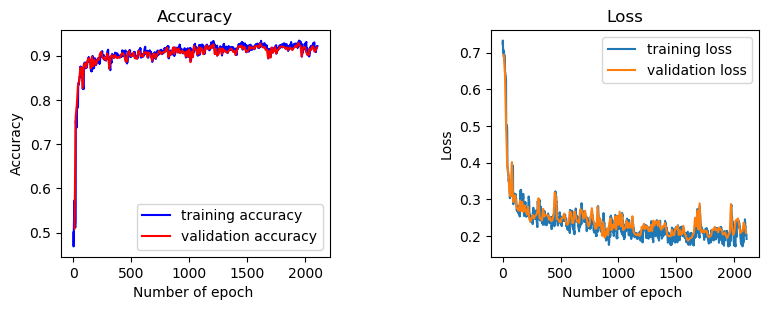

In [46]:
mm.plot_acc_loss(steps_loss_train=histories_per_step.steps, loss_train=histories_per_step.losses,
                 steps_acc_train=histories_per_step.steps, accuracy_train=histories_per_step.accuracies,
                 steps_loss_eval=histories_per_step.val_steps, loss_eval=histories_per_step.val_losses,
                 steps_acc_eval=histories_per_step.val_steps, accuracy_eval=histories_per_step.val_accuracies)

### Get more information

In [47]:
print(model.metrics)
print(model.metrics_names)

[<tensorflow.python.keras.metrics.Mean object at 0x7fbac96167d0>, <tensorflow.python.keras.metrics.SparseCategoricalAccuracy object at 0x7fbac967c2d0>]
['loss', 'accuracy']


In [48]:
history.epoch

[0]

In [49]:
history.params

{'verbose': 1, 'epochs': 1, 'steps': 2105}

In [50]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [51]:
# dir(history)

### Exploration of the model's structure

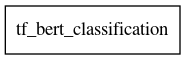

In [52]:
tf.keras.utils.plot_model(model,
                          'model.png',
                          show_shapes=True)

In [53]:
model.inputs

In [54]:
model.outputs

In [55]:
model.layers

In [56]:
# _inbound_nodes and inbound_nodes give the same !
# to see method available: dir(model.layers[2])
for layer in model.layers:
    print(layer.name, layer._inbound_nodes, layer._outbound_nodes)

bert [] []
dropout_37 [] []
classifier [] []


### Validation of the model

#### Making prediction

In [57]:
# get probablility for each classes
if model.name=='custom_tf_bert_classification':
        print('custom model: {}'.format(model.name))
        y_pred = tf.nn.softmax(model.predict(valid_dataset))
elif model.name=='tf_bert_classification':
        print('standard model: {}'.format(model.name))
        y_pred = tf.squeeze(tf.nn.softmax(model.predict(valid_dataset)))

standard model: tf_bert_classification


In [58]:
y_pred.shape

TensorShape([872, 2])

In [59]:
# get predicted classes
y_pred_argmax = tf.math.argmax(y_pred, axis=1)        

In [60]:
(y_pred_argmax).shape

TensorShape([872])

#### Extracting true classes

In [61]:
# extracting and flatten true classes
y_true_tf=valid_dataset.map(pp.label_extraction).flat_map(lambda x: valid_dataset.from_tensor_slices(x))

In [62]:
y_true=list(y_true_tf.as_numpy_iterator())

In [63]:
len(y_true), len(y_pred_argmax)

(872, 872)

#### Model performanes

In [64]:
print(classification_report(y_true, y_pred_argmax, target_names=info.features["label"].names))

              precision    recall  f1-score   support

    negative       0.94      0.89      0.91       428
    positive       0.90      0.95      0.92       444

    accuracy                           0.92       872
   macro avg       0.92      0.92      0.92       872
weighted avg       0.92      0.92      0.92       872



In [65]:
mm.print_metrics(y_true, y_pred_argmax, mode='')

Model performance on the  dataset:
   Metric             
accuracy...........   0.9186
recall.............   0.9459
auc................   0.9181
precision (p=0.5)..   0.8994
precision (avg)....   0.8783
precision (micro)..   0.9186
precision (macro)..   0.9200
f1.................    0.9221
r2.................    0.6742


#### Confusion matrix

In [66]:
plt.rcParams['figure.figsize'] = [10, 7]

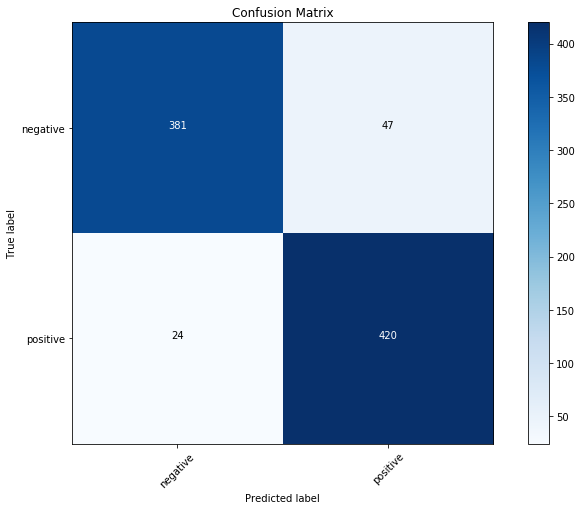

In [67]:
mm.plot_confusion_matrix(confusion_matrix(y_true, y_pred_argmax), info.features["label"].names)

#### ROC curves

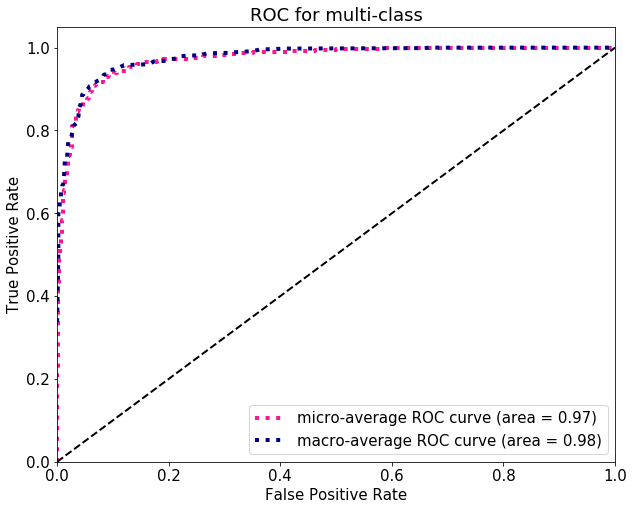

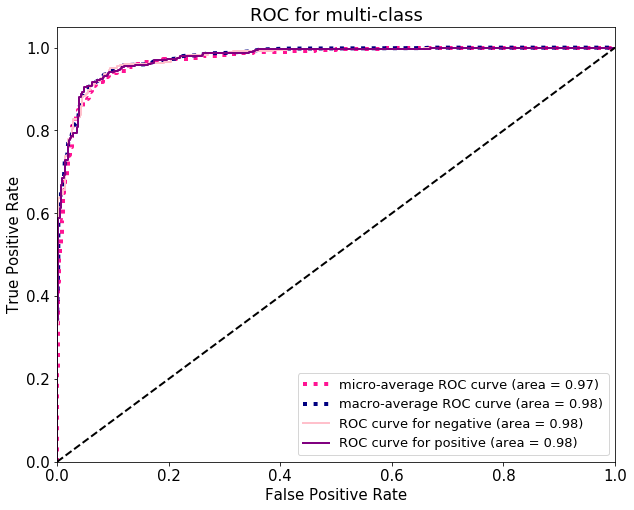

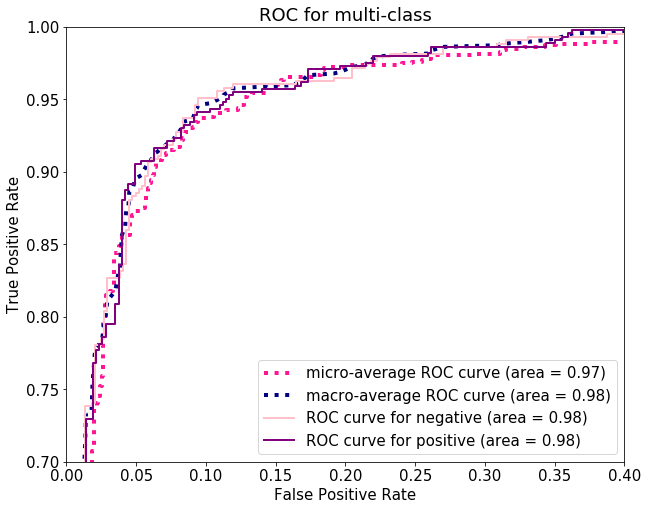

In [68]:
mm.roc_curves(to_categorical(y_true), y_pred.numpy(), info.features["label"].names)